# (...)

(...)

## Concatenate Georoc database

In [18]:
import sys
import getpass
print("User :", getpass.getuser())
print("Python version :", sys.version)
%load_ext watermark
%watermark -i -v -m -p pandas,numpy,matplotlib,sklearn

User : simonje
Python version : 3.6.1 | packaged by conda-forge | (default, May 23 2017, 14:21:39) [MSC v.1900 64 bit (AMD64)]
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-07-07T12:45:51-04:00

CPython 3.6.1
IPython 6.1.0

pandas 0.20.2
numpy 1.13.0
matplotlib 2.0.0
sklearn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 26 Stepping 5, GenuineIntel
CPU cores  : 16
interpreter: 64bit


In [19]:
%matplotlib inline

import time
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from itertools import count, cycle
from sklearn.svm import SVC
from sklearn.metrics import (f1_score, make_scorer, confusion_matrix, mean_absolute_error, 
                             median_absolute_error, mean_squared_error)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeavePGroupsOut

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

### Concatenation

Concatenation of the *.csv* files contained in */Georoc_files* into a single *master.csv* file at source.

In [14]:
# Files from /Georoc_files are opened one by one and stored as DataFrames in the *files* list.

dir_ = os.curdir + '/Georoc_files'
files = os.listdir(dir_)

nb_data = 0

for file, file_no in zip(files, count()):

    file = pd.read_csv(dir_ + '/' + file, encoding='iso-8859-1', dtype=object)

    index = np.where(file.CITATIONS.values == 'References:')[0][0]
    file = file[:index]
    file.insert(0, 'FILENAME', files[file_no])

    nb_data += file.shape[0]
    files[file_no] = file

In [15]:
# Files are regrouped in *master_file*. *nb_data* was needed because of the *.append* method being resources-expensive.

master_file = pd.DataFrame(index=np.arange(0, nb_data), columns=files[0].axes[1])
current_row = 0

row_no = 0
for file in files:
    for _, row in file.iterrows():
        master_file.loc[row_no] = row
        row_no += 1

file = None

In [16]:
# Volcanic rocks, duplicates and unnecessary columns are removed, and tectonics settings are formatted identically.

master_file = master_file[master_file['ROCK TYPE'] == 'VOLCANIC ROCK']
master_file.drop_duplicates(subset='UNIQUE_ID', inplace=True)
master_file.drop('Unnamed: 171', axis=1, inplace=True)

master_file['TECTONIC SETTING'] = master_file['TECTONIC SETTING'].str.upper()

master_file = master_file.reset_index(drop=True)  # Removing data messes with the indexing

In [17]:
# Data under limit of detection is formatted to half the limit of detection.

for row_no, row in master_file.iloc[:, 29:171].iterrows():
    for col_no, data in zip(count(), row):
        data = str(data).strip()

        if data[0] == '-':  # Data under limit of detection has format *-data*. *<data* is not used
            master_file.iloc[row_no, col_no + 29] = -float(data) / 2

        # elif data[0] == '<':
        #     print(master_file.iloc[row_no, col_no + 29])
        #     master_file.iloc[row_no, col_no + 29] = float(data.lstrip(['<', '='])) / 2
        #     print(master_file.iloc[row_no, col_no + 29])
        # else:
        #     data = float(data)  # failsafe

In [18]:
# Data is saved in *master.csv* at source, allowing it to be reloaded for future uses.

master_file.to_csv(os.curdir + '/master.csv', index=False)

### Load master

In [3]:
# Should be used on reloads to produce faster results.

master_file = pd.read_csv(os.curdir + '/master.csv', encoding='iso-8859-1', dtype=object)

### Statistics

In [19]:
print ('Shape of the dataset after transformation:' + str(master_file.shape))
master_file.head()

Shape of the dataset after transformation:(273918, 172)


,FILENAME,CITATIONS,TECTONIC SETTING,LOCATION,LOCATION COMMENT,LATITUDE MIN,LATITUDE MAX,LONGITUDE MIN,LONGITUDE MAX,LAND OR SEA,ELEVATION MIN,ELEVATION MAX,SAMPLE NAME,ROCK NAME,MIN. AGE (YRS.),MAX. AGE (YRS.),GEOL.,AGE,ERUPTION DAY,ERUPTION MONTH,ERUPTION YEAR,ROCK TEXTURE,ROCK TYPE,DRILL DEPTH MIN,DRILL DEPTHAX,ALTERATION,MINERAL,MATERIAL,SIO2(WT%),TIO2(WT%),B2O3(WT%),AL2O3(WT%),CR2O3(WT%),FE2O3(WT%),FEO(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),NIO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),H2O(WT%),H2OP(WT%),H2OM(WT%),H2OT(WT%),CO2(WT%),CO1(WT%),F(WT%),CL(WT%),CL2(WT%),OH(WT%),CH4(WT%),SO2(WT%),SO3(WT%),SO4(WT%),S(WT%),LOI(WT%),VOLATILES(WT%),O(WT%),OTHERS(WT%),HE(CCM/G),HE(CCMSTP/G),HE3(CCMSTP/G),HE3(AT/G),HE4(CCM/G),HE4(CCMSTP/G),HE4(AT/G),HE4(MOLE/G),HE4(NCC/G),HE(NCC/G),LI(PPM),BE(PPM),B(PPM),...,GE(PPM),AS(PPM),SE(PPM),BR(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),MO(PPM),RU(PPM),RH(PPM),PD(PPM),AG(PPM),CD(PPM),IN(PPM),SN(PPM),SB(PPM),TE(PPM),I(PPM),CS(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),HO(PPM),ER(PPM),TM(PPM),YB(PPM),LU(PPM),HF(PPM),TA(PPM),W(PPM),RE(PPM),OS(PPM),IR(PPM),PT(PPM),AU(PPM),HG(PPM),TL(PPM),PB(PPM),BI(PPM),TH(PPM),U(PPM),ND143_ND144,ND143_ND144_INI,EPSILON_ND,SR87_SR86,SR87_SR86_INI,PB206_PB204,PB206_PB204_INI,PB207_PB204,PB207_PB204_INI,PB208_PB204,PB208_PB204_INI,OS184_OS188,OS186_OS188,OS187_OS186,OS187_OS188,RE187_OS186,RE187_OS188,HF176_HF177,HE3_HE4,HE3_HE4(R/R(A)),HE4_HE3,HE4_HE3(R/R(A)),K40_AR40,AR40_K40,UNIQUE_ID
0,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 88 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],44.59,2.79,NaN,11.06,NaN,NaN,NaN,11.79,10.95,8.86,0.18,NaN,2.37,3.19,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31,575,26.4,269,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,52.5,101,12,50.9,10,2.86,9.1,1.25,5.84,0.98,2.61,0.32,1.79,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.4,1.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336642
1,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 124 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],40.38,2.79,NaN,10.27,NaN,NaN,NaN,9.25,16.76,9.18,0.16,NaN,0.74,5.09,0.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18,688,26.4,284,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391,67.1,129,16,66.2,12.5,3.61,10.5,1.41,6.74,1.01,2.58,0.3,1.75,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.06,2.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336643
2,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 125 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],42.56,2.78,NaN,10.45,NaN,NaN,NaN,8.88,15.98,10.05,0.14,NaN,1.5,3.91,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,22,680,23.7,282,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,673,54,109,13.5,58,11.3,3.43,10,1.34,5.86,0.95,2.32,0.26,1.65,0.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.79,1.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336644
3,ADRIA_DOMAIN.csv,[11689],INTRAPLATE VOLCANICS,ADRIA DOMAIN / SOUTHERN ALPS / VENETO VOLCANIC...,NaN,45.83,45.83,11.17,11.17,SUBAERIAL,NaN,

In [20]:
# Column names

pd.Series(master_file.axes[1])

0              FILENAME
1             CITATIONS
2      TECTONIC SETTING
3              LOCATION
4      LOCATION COMMENT
5          LATITUDE MIN
6          LATITUDE MAX
7         LONGITUDE MIN
8         LONGITUDE MAX
9           LAND OR SEA
10        ELEVATION MIN
11        ELEVATION MAX
12          SAMPLE NAME
13            ROCK NAME
14      MIN. AGE (YRS.)
15      MAX. AGE (YRS.)
16                GEOL.
17                  AGE
18         ERUPTION DAY
19       ERUPTION MONTH
20        ERUPTION YEAR
21         ROCK TEXTURE
22            ROCK TYPE
23      DRILL DEPTH MIN
24        DRILL DEPTHAX
25           ALTERATION
26              MINERAL
27             MATERIAL
28            SIO2(WT%)
29            TIO2(WT%)
30            B2O3(WT%)
31           AL2O3(WT%)
32           CR2O3(WT%)
33           FE2O3(WT%)
34             FEO(WT%)
35            FEOT(WT%)
36             CAO(WT%)
37             MGO(WT%)
38             MNO(WT%)
39             NIO(WT%)
40             K2O(WT%)
41            NA

In [21]:
# Samples contained per file

master_file['FILENAME'].value_counts()

APENNINIC-MAGHREBIDES_CHAIN.csv                        10571
ICELAND.csv                                             9163
HAWAIIAN_ISLANDS_1.csv                                  8058
HONSHU_ARC_1.csv                                        7657
YELLOWSTONE-SNAKE_RIVER_PLAIN_VOLCANIC_PROVINCE.csv     7093
ANATOLIA-IRAN_BELT_-_CENOZOIC_QUATERNARY.csv            6572
ANDEAN_ARC_1.csv                                        6412
CENTRAL_ASIAN_FOLDBELT_-_CENOZOIC_QUATERNARY.csv        6319
ANDEAN_ARC_2.csv                                        6303
EAST_AFRICAN_RIFT.csv                                   6183
IZU-BONIN_ARC.csv                                       5658
HONSHU_ARC_2.csv                                        5375
MEXICAN_VOLCANIC_BELTS.csv                              5069
BASIN_AND_RANGE_-_GREAT_BASIN.csv                       4925
NORTH_ATLANTIC_IGNEOUS_PROVINCE_OR_NAIP.csv             4621
NEW_ZEALAND.csv                                         4455
CASCADES.csv            

In [22]:
# Samples obtained per location

master_file['LOCATION'].value_counts()

ICELAND / ICELAND / NORTHERN ICELAND RIFT ZONE / ATLANTIC OCEAN                                                                                                           2007
ICELAND / ICELAND / ATLANTIC OCEAN                                                                                                                                        1968
YELLOWSTONE-SNAKE RIVER PLAIN VOLCANIC PROVINCE / COLUMBIA PLATEAU-BLUE MOUNTAINS PROVINCE / GRANDE RONDE BASALT                                                          1661
HAWAIIAN ISLANDS / HAWAII / KILAUEA / SHIELD STAGE / EAST RIFT ZONE / PUU OO ERUPTION / PACIFIC OCEAN                                                                     1599
CAPE VERDE ISLANDS / FOGO / ATLANTIC OCEAN                                                                                                                                1424
DECCAN / NORTHERN DECCAN                                                                                                     

In [23]:
# Samples obtained per rock name

temp = master_file['ROCK NAME'].value_counts()
filter_ = r'\[(\d)*\]'

# Citations are removed from the index so that identical rock names have identical indexes.
temp.index = temp.index.astype(str).str.replace(filter_,'').str.strip().str.replace('  ',' ')

# Samples with identical rock names are regrouped
temp = temp.groupby(temp.index).sum().sort_values(ascending=False)
print(temp)

NOT GIVEN                                                                    54856
BASALT                                                                       54381
ANDESITE                                                                     19487
RHYOLITE                                                                     17287
THOLEIITE                                                                    11967
ANDESITE, BASALTIC                                                           11047
DACITE                                                                       10120
BASALT, ALKALINE                                                              7692
TRACHYTE                                                                      5041
BASANITE                                                                      4748
KIMBERLITE                                                                    4501
BASALT, THOLEIITIC                                                            3645
KOMA

In [24]:
# Samples obtained per rock name

master_file['TECTONIC SETTING'].value_counts()

CONVERGENT MARGIN                              96893
INTRAPLATE VOLCANICS                           56864
OCEAN ISLAND                                   41105
CONTINENTAL FLOOD BASALT                       31614
RIFT VOLCANICS                                 19066
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)    14265
SEAMOUNT                                        6519
OCEANIC PLATEAU                                 2903
COMPLEX VOLCANIC SETTINGS                       2479
SUBMARINE RIDGE                                 1392
OCEAN-BASIN FLOOD BASALT                         818
Name: TECTONIC SETTING, dtype: int64

### QA/QC

Elements columns that aren't full enough are dropped. Next, samples with missing observations in the remaining columns are dropped.

In [6]:
# Number of missing observations per element

a = master_file.iloc[:, 29:-1].count(axis=0)
a = len(master_file.index) - a
print(a)

TIO2(WT%)           46102
B2O3(WT%)          273908
AL2O3(WT%)          46460
CR2O3(WT%)         267847
FE2O3(WT%)         200277
FEO(WT%)           205416
FEOT(WT%)          116191
CAO(WT%)            46397
MGO(WT%)            44739
MNO(WT%)            52942
NIO(WT%)           271435
K2O(WT%)            41384
NA2O(WT%)           47593
P2O5(WT%)           59461
H2O(WT%)           255227
H2OP(WT%)          242983
H2OM(WT%)          248055
H2OT(WT%)          273918
CO2(WT%)           252808
CO1(WT%)           273894
F(WT%)             266835
CL(WT%)            263599
CL2(WT%)           273615
OH(WT%)            273672
CH4(WT%)           273902
SO2(WT%)           273169
SO3(WT%)           268957
SO4(WT%)           273884
S(WT%)             264383
LOI(WT%)           164921
VOLATILES(WT%)     273918
O(WT%)             273916
OTHERS(WT%)        273895
HE(CCM/G)          273918
HE(CCMSTP/G)       272969
HE3(CCMSTP/G)      273918
HE3(AT/G)          273918
HE4(CCM/G)         273918
HE4(CCMSTP/G

In [7]:
# Elements with quantity of observations over *value* are dropped, with the exception of elements 
# in *index_keep*, and with the addition of elements in *index_drop*.

# PARAMETERS #
value = 148000  # Deletion threshold
index_drop = []  # Deleted elements
index_keep = []  # Preserved elements
##############

index_ = (a > value) & ~ a.index.isin(index_keep) | a.index.isin(index_drop)

In [8]:
# A file with deleted data is created. The original is unaltered.

filtered_file = master_file.copy();

# Removes columns with too many missing data
filtered_file.drop(a[index_].index.values, axis=1, inplace=True)

# Removes samples with missing data
filtered_file.dropna(subset=a[~ index_].index.values, inplace=True)

filtered_file = filtered_file.reset_index(drop=True)  # Removing data messes with the indexing

In [9]:
print('Shape of the dataset after transformation:', str(filtered_file.shape), 'Out of:', str(master_file.shape), '\n')
print(filtered_file.iloc[:, 29:-1].axes[1])
filtered_file.head()

Shape of the dataset after transformation: (57107, 50) Out of: (273918, 172) 

Index(['TIO2(WT%)', 'AL2O3(WT%)', 'FEOT(WT%)', 'CAO(WT%)', 'MGO(WT%)',
       'MNO(WT%)', 'K2O(WT%)', 'NA2O(WT%)', 'P2O5(WT%)', 'V(PPM)', 'CR(PPM)',
       'NI(PPM)', 'RB(PPM)', 'SR(PPM)', 'Y(PPM)', 'ZR(PPM)', 'NB(PPM)',
       'BA(PPM)', 'LA(PPM)', 'CE(PPM)'],
      dtype='object')


,FILENAME,CITATIONS,TECTONIC SETTING,LOCATION,LOCATION COMMENT,LATITUDE MIN,LATITUDE MAX,LONGITUDE MIN,LONGITUDE MAX,LAND OR SEA,ELEVATION MIN,ELEVATION MAX,SAMPLE NAME,ROCK NAME,MIN. AGE (YRS.),MAX. AGE (YRS.),GEOL.,AGE,ERUPTION DAY,ERUPTION MONTH,ERUPTION YEAR,ROCK TEXTURE,ROCK TYPE,DRILL DEPTH MIN,DRILL DEPTHAX,ALTERATION,MINERAL,MATERIAL,SIO2(WT%),TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),V(PPM),CR(PPM),NI(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),BA(PPM),LA(PPM),CE(PPM),UNIQUE_ID
0,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 88 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],44.59,2.79,11.06,11.79,10.95,8.86,0.18,2.37,3.19,0.79,235,302,206,31,575,26.4,269,74,707,52.5,101,336642
1,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 124 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],40.38,2.79,10.27,9.25,16.76,9.18,0.16,0.74,5.09,0.82,234,112,59,18,688,26.4,284,89,391,67.1,129,336643
2,ADRIA_DOMAIN.csv,[11431],INTRAPLATE VOLCANICS,ADRIA DOMAIN / ADRIATIC FORELAND / APULIA / PI...,NaN,39.5,40.5,16,16.5,SUBAERIAL,NaN,NaN,s 125 [11431],NOT GIVEN [11431],NaN,NaN,NaN,PALEOGENE [11431],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [11431],42.56,2.78,10.45,8.88,15.98,10.05,0.14,1.5,3.91,0.83,232,232,69,22,680,23.7,282,68,673,54,109,336644
3,ADRIA_DOMAIN.csv,[9694],INTRAPLATE VOLCANICS,ADRIA DOMAIN / SOUTHERN ALPS / VENETO VOLCANIC...,NaN,45.68,45.68,11.22,11.22,SUBAERIAL,NaN,NaN,s 5MB [9694],BASANITE [9694],NaN,NaN,NaN,PALEOGENE [9694],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [9694],42.45,2.98,12.91,12.02,10.49,11.12,0.19,1.77,3.06,1.09,243,304,259,39.5,937,28.6,258,63.8,807,68.6,131,487564
4,ADRIA_DOMAIN.csv,[9694],INTRAPLATE VOLCANICS,ADRIA DOMAIN / SOUTHERN ALPS / VENETO VOLCANIC...,NaN,45.68,45.68,11.22,11.22,SUBAERIAL,NaN,NaN,s 6MB [9694],BASANITE [9694],NaN,NaN,NaN,PALEOGENE [9694],NaN,NaN,NaN,NaN,VOLCANIC ROCK,NaN,NaN,NaN,NaN,WHOLE_ROCK [9694],42.17,2.92,12.8,12.03,10.36,11.39,0.19,1.63,3.11,0.99,242,312,282,38.1,943,28.9,254,61.9,799,67.8,129,487565


## Analysis

### 1) SVM

In [10]:
# Creation of X and y.

X = filtered_file.iloc[:, 29:-1]
y = filtered_file['TECTONIC SETTING']

In [101]:
# Creation of training and testing sets.

lpgo = LeavePGroupsOut(n_groups=10)
groups = filtered_file.groupby('FILENAME').apply(lambda group: group.index.values)
groups = groups.values
print(groups)
print(lpgo.get_n_splits(X, y, groups))

train_index, test_index = lpgo.split(X, y, groups)[test_no]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=42)

[ array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)
 array([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179,

ValueError: Found input variables with inconsistent numbers of samples: [57107, 57107, 295]

In [13]:
# Initialization.

C_range = 10.0 ** np.arange(1, 4)
gamma_range= 10.0 ** np.arange(-2, 1)
param_grid = dict(svc__C=C_range, svc__gamma=gamma_range)
SVM = make_pipeline(StandardScaler(), SVC(cache_size=2000))
f1_scorer = make_scorer(f1_score, average='weighted')

In [14]:
# Launching the grid search.

start = datetime.datetime.now()
print("Start time :", start)

grid = GridSearchCV(SVM, param_grid, cv=3, scoring=f1_scorer, n_jobs=-1, verbose=2)
#clf = grid.get_params()
clf = grid.fit(X_train, y_train)

end = datetime.datetime.now()
print("Start time :", end)
print("Time elapsed :", end - start, '\n')

print("Best parameters set found on development set:")
print(clf.cv_results_['params'][clf.best_index_])
print("Score: %0.03f" % clf.best_score_)

Start time : 2017-07-07 12:41:10.415557
Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   38.5s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   59.9s finished


Start time : 2017-07-07 12:42:48.045259
Time elapsed : 0:01:37.629702 

Best parameters set found on development set:
{'svc__C': 100.0, 'svc__gamma': 0.10000000000000001}
Score: 0.718


[[ 0.61447446  0.70229566  0.70850451]
 [ 0.65281245  0.7181035   0.70601995]
 [ 0.68426052  0.7114608   0.70602668]]


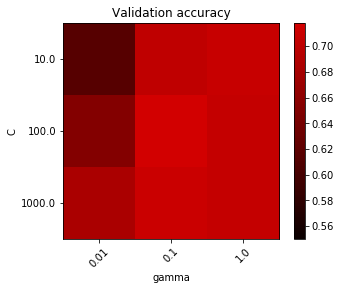

In [25]:
# Visualizing score per combination.

from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

scores = clf.cv_results_['mean_test_score'].reshape((len(C_range), len(gamma_range)))
print(scores)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.55, midpoint=0.83))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [47]:
# Selecting the best parameters and estimating success scores on test data.

best_C     = 100
best_gamma = 0.1

SVM = make_pipeline(StandardScaler(), SVC(C=best_C, gamma=best_gamma, cache_size=2000))
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)

['ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)' 'COMPLEX VOLCANIC SETTINGS'
 'CONTINENTAL FLOOD BASALT' 'CONVERGENT MARGIN' 'INTRAPLATE VOLCANICS'
 'OCEAN ISLAND' 'OCEAN-BASIN FLOOD BASALT' 'OCEANIC PLATEAU'
 'RIFT VOLCANICS' 'SEAMOUNT' 'SUBMARINE RIDGE']
f1: 0.758899814479


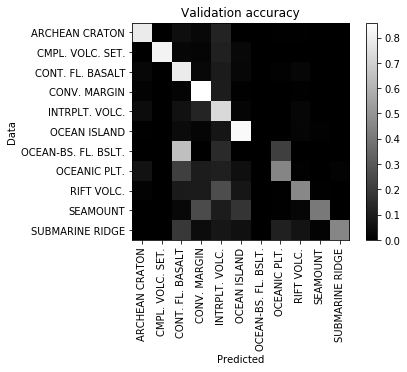

In [70]:
# Analysis

f1 = f1_score(y_test, y_pred, average='weighted')

conf = confusion_matrix(y_test, y_pred)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]  # Normalize
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.gray)
plt.xlabel('Predicted')
plt.ylabel('Data')
plt.colorbar()
range_ = np.arange(len(labels))
labels = SVM.classes_
print(labels)
labels = ['ARCHEAN CRATON',  # VERIFY LABELING
          'CMPL. VOLC. SET.',
          'CONT. FL. BASALT',
          'CONV. MARGIN',
          'INTRPLT. VOLC.',
          'OCEAN ISLAND',
          'OCEAN-BS. FL. BSLT.',
          'OCEANIC PLT.',
          'RIFT VOLC.',
          'SEAMOUNT',
          'SUBMARINE RIDGE']
plt.xticks(range_, labels, rotation=90)
plt.yticks(range_, labels)
plt.title('Validation accuracy')

print('f1:', str(f1))
plt.show()

### 2) Nearest Neighbors